In [2]:
import mplfinance as mpf
import pymssql
import json
import pandas as pd
import numpy as np


In [3]:
def connect_SQL_server():
    db_settings = {
        "host": "127.0.0.1",
        "port": 1433,
        "user": "johnnyhsu",
        "password": "12345678",
        "database": "ncu_database",
        "charset": "UTF-8"
    }

    conn  = pymssql.connect(**db_settings)
    return conn

In [9]:
def get_data(company, start, end, cursor):

    command = f"""SELECT [date],[o],[h],[l],[c],[v],[MA5],[MA10]
            FROM [dbo].[price_history] 
            where [stock_code] = {company} AND date > '{start}' AND date < '{end}'
            AND ( year(date) = 2022 or year(date) = 2021 )"""
    cursor.execute(command)

    arr = []
    row = cursor.fetchone()  
    while row:
        arr.append(row)
        row = cursor.fetchone()
    
    arr_df = pd.DataFrame(arr)
    arr_df['Date'] = pd.to_datetime(arr_df[0])
    arr_df = arr_df.sort_values(by="Date")
    arr_df = arr_df.drop(columns=[0]) # remove extra date column
    arr_df.set_index("Date",inplace=True)
    
    arr_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume','MA5','MA10']

    return arr_df

In [10]:
def get_turning_wave(company, start, end, cursor):
    command = f"""select end_day, end_day_price, trend
            from find_trend('{company}')
            where end_day > '{start}' and end_day < '{end}'
            order by end_day asc
          """
    cursor.execute(command)

    arr = []
    row = cursor.fetchone()  
    while row:
        arr.append(row)
        row = cursor.fetchone()
    
    df = pd.DataFrame(arr)
    df.columns = ['date', 'close_price', 'trend']
    df.loc[:, 'date'] = pd.to_datetime(df['date'])
    
    # 開始找轉折點 -> 從日期最大的找起
    df_result = pd.DataFrame()

    # 先取得第一個趨勢
    cur_trend = 0
    for idx in range(df['date'].size - 1, 0, -1):
        if df.loc[idx, 'trend'] != 0:
            cur_trend = df.loc[idx, 'trend']
            break

    cur_max_min = 0 # 根據當前趨勢，去暫存最大或最小收盤價 
    cur_start_day = np.nan
    for idx in range(df['date'].size - 1, -1, -1):
        # 趨勢轉變 跟 最後一筆時, 儲存資訊
        if (df.loc[idx, 'trend'] != 0 and df.loc[idx, 'trend'] != cur_trend) or idx == 0:
            # save
            df_tmp = pd.DataFrame([[cur_start_day, np.nan, cur_max_min, cur_trend]],
                   columns=['start_day', 'end_day', 'close_price', 'trend'])
            df_result = pd.concat([df_tmp, df_result])
            
            # reset
            cur_trend = df.loc[idx, 'trend']
            cur_max_min = 0
        
        if cur_trend == 1: # find max
            if df.loc[idx, 'close_price'] > cur_max_min:
                cur_max_min = df.loc[idx, 'close_price']
                cur_start_day = df.loc[idx, 'date']
        else: # cur_tend == -1, find min
            if df.loc[idx, 'close_price'] < cur_max_min or cur_max_min == 0:
                cur_max_min = df.loc[idx, 'close_price']
                cur_start_day = df.loc[idx, 'date']
    
    # reset index because the indices would all be zeros
    df_result.reset_index(drop=True, inplace=True)
    
    # 新增 end day
    df_result['end_day'] = df_result['start_day'].shift()
    # 因為第0筆沒有資料，直接放入最舊的日期
    df_result.loc[0, 'end_day'] = df.loc[0, 'date']
    
    return df_result

In [11]:
conn = connect_SQL_server()
cursor = conn.cursor()

In [12]:
company = '2330'
day_start = '20210101'
day_end = '20220228'

In [13]:
df = get_data(company, day_start, day_end, cursor)
df

,Open,High,Low,Close,Volume,MA5,MA10
Date,,,,,,,
2021-01-04,530.0,540.0,528.0,536.0,33316,536.000000,536.000000
2021-01-05,536.0,542.0,535.0,542.0,28512,539.000000,539.000000
2021-01-06,555.0,555.0,541.0,549.0,55462,542.333313,542.333313
2021-01-07,554.0,570.0,553.0,565.0,47905,548.000000,548.000000
2021-01-08,580.0,580.0,571.0,580.0,56426,554.400024,554.400024
...,...,...,...,...,...,...,...
2022-02-21,633.0,636.0,632.0,632.0,41961,638.599976,639.000000
2022-02-22,628.0,630.0,625.0,627.0,68303,637.400024,638.900024
2022-02-23,624.0,629.0,623.0,625.0,50926,633.200012,638.099976


In [14]:
turning_wave = get_turning_wave(company, day_start, day_end, cursor)
turning_wave

C:\Users\johnn\AppData\Local\Temp\ipykernel_16564\584357608.py:17: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'date'] = pd.to_datetime(df['date'])


,start_day,end_day,close_price,trend
0,2021-03-25,2021-03-09,575.0,-1
1,2021-04-15,2021-03-25,619.0,1
2,2021-05-13,2021-04-15,547.0,-1
3,2021-07-15,2021-05-13,614.0,1
4,2021-08-20,2021-07-15,552.0,-1
5,2021-09-06,2021-08-20,631.0,1
6,2021-10-06,2021-09-06,571.0,-1
7,2021-11-19,2021-10-06,618.0,1
8,2021-11-29,2021-11-19,593.0,-1
9,2022-01-17,2021-11-29,683.0,1


In [15]:
datepairs_turning_wave = [(d1, d2) for d1, d2 in zip(turning_wave['end_day'], turning_wave['start_day'])]

print(datepairs_turning_wave)

[(Timestamp('2021-03-09 00:00:00'), Timestamp('2021-03-25 00:00:00')), (Timestamp('2021-03-25 00:00:00'), Timestamp('2021-04-15 00:00:00')), (Timestamp('2021-04-15 00:00:00'), Timestamp('2021-05-13 00:00:00')), (Timestamp('2021-05-13 00:00:00'), Timestamp('2021-07-15 00:00:00')), (Timestamp('2021-07-15 00:00:00'), Timestamp('2021-08-20 00:00:00')), (Timestamp('2021-08-20 00:00:00'), Timestamp('2021-09-06 00:00:00')), (Timestamp('2021-09-06 00:00:00'), Timestamp('2021-10-06 00:00:00')), (Timestamp('2021-10-06 00:00:00'), Timestamp('2021-11-19 00:00:00')), (Timestamp('2021-11-19 00:00:00'), Timestamp('2021-11-29 00:00:00')), (Timestamp('2021-11-29 00:00:00'), Timestamp('2022-01-17 00:00:00'))]


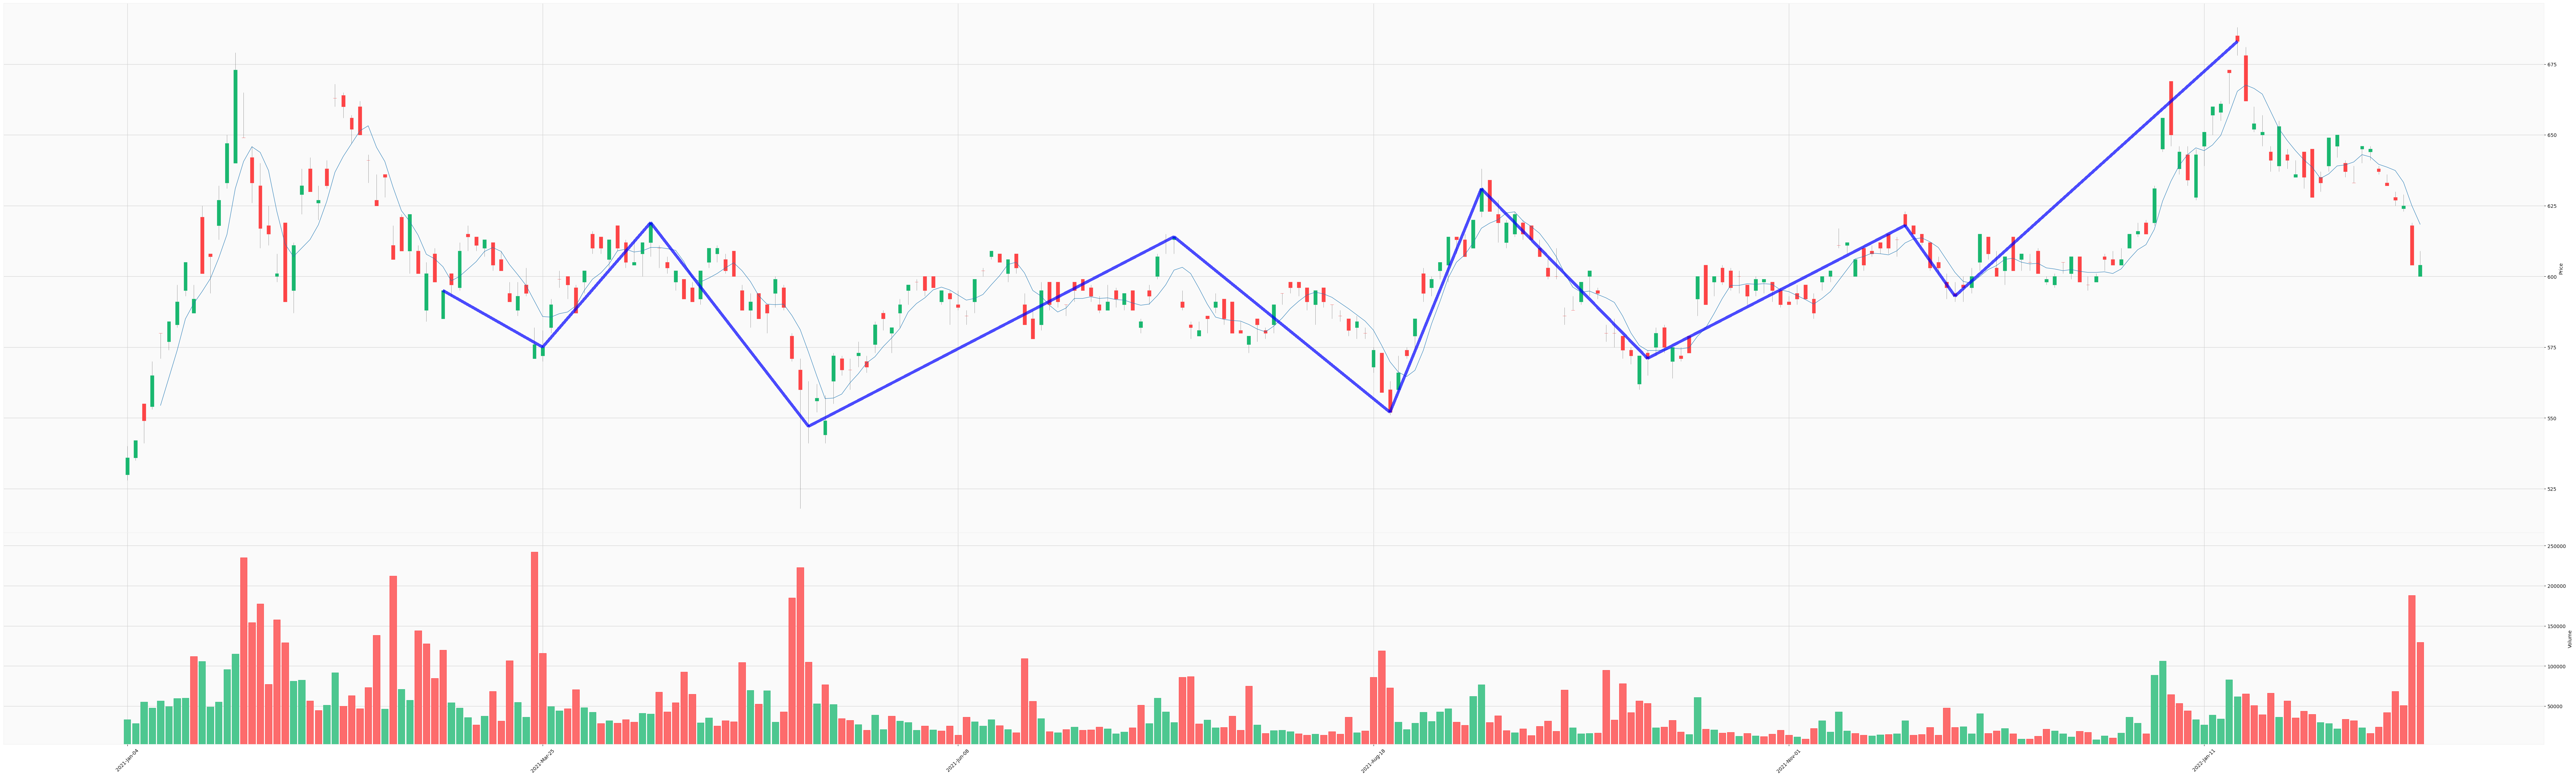

<function matplotlib.pyplot.show(close=None, block=None)>

In [16]:
mpf.plot(df, type='candle', style='yahoo', mav = (5), volume = True, figsize=(100,30),
                 tlines = [dict(tlines=datepairs_turning_wave, tline_use='close', colors='b', linewidths=5, alpha=0.7)])
mpf.show
